## TGF-β Signaling Pathway Model

This notebook studies parameters identifiability of the **TGF-β signaling pathway model** proposed in [Geier F, Fengos G, Felizzi F, Iber D. Analyzing and Constraining Signaling Networks](https://link.springer.com/book/10.1007%2F978-1-61779-833-7). Identifiability of this model was analyzed in this article \[\*\] [Parameter identifiability analysis and visualization in large-scale kinetic models of biosystems](https://bmcsystbiol.biomedcentral.com/articles/10.1186/s12918-017-0428-y). We used the equations and datasets provided by the authors of this article in the use-cases of [visid](https://github.com/gabora/visid) software. Our goal is to compare *LikelihoodProfiler* results with the results of \[\*\]. 

The following ODE system defines the **TGF-β signaling pathway model**

In [2]:
using DiffEqBase, OrdinaryDiffEq, Sundials, CSV, Plots, NLopt, LikelihoodProfiler, DataFrames

# ODE function
function ode_func(du,u,p,t)
    #parameters
    k1, k2, k4, k5, k6, k7, k8, k9, k10, k11, k12, k13, k14, k15, k16, k17, k18, k19 = p
    k3 = 0.01
    k20 = 9000.
    k21 = 1800.
    
    # concentrations (all concencentrations except I_Smad_mRNA1, I_Smad_mRNA2 are observed in the experiment)
    TGFb, TGFbR, TGFb_TGFbR, TGFb_TGFbR_P, I_Smad_TGFb_TGFbR_P, Smad, Smad_P, CoSmad, Smad_P_Smad_P, Smad_P_CoSmad, 
    Smad_N, Smad_P_Smad_P_N, Smad_P_N, Smad_P_CoSmad_N, CoSmad_N, I_Smad, I_Smad_mRNA1, I_Smad_mRNA2 = u

    # kinetic rates
    r1 = k1*TGFb_TGFbR                                   
    r2 = k2*TGFbR*TGFb                                   
    r3 = k3*TGFb_TGFbR*(1-exp(-((t-k20)/(k21))^10))      
    r4 = k4*TGFb_TGFbR_P                                 
    r5 = k5*TGFb_TGFbR_P*I_Smad                          
    r6 = k6*I_Smad_TGFb_TGFbR_P                          
    r7 = k7*Smad*TGFb_TGFbR_P                            
    r8 = k8*Smad                                         
    r9 = k9*Smad_N                                       
    r10 = k10*2*Smad_P*Smad_P                            
    r11 = k11*Smad_P_Smad_P                              
    r12 = k10*Smad_P*CoSmad                              
    r13 = k11*Smad_P_CoSmad                              
    r14 = k8*CoSmad                                      
    r15 = k9*CoSmad_N                                    
    r16 = k12*k8*Smad_P_Smad_P                           
    r17 = k8*Smad_P                                      
    r18 = k9*Smad_P_N                                    
    r19 = k12*k8*Smad_P_CoSmad                           
    r20 = k13*Smad_P_N                                   
    r21 = k10*2*Smad_P_N*Smad_P_N                        
    r22 = k11*Smad_P_Smad_P_N                            
    r23 = k10*Smad_P_N*CoSmad_N                          
    r24 = k11*Smad_P_CoSmad_N                            
    r25 = k14*Smad_P_CoSmad_N^2/(Smad_P_CoSmad_N^2+k15^2)
    r26 = k16*I_Smad_mRNA1                               
    r27 = k17*I_Smad_mRNA2                               
    r28 = k18*I_Smad_mRNA2                               
    r29 = k19*I_Smad                                     
        
    # rhs
    du[1] = r1-r2                                         
    du[2] = r1-r2                                        
    du[3] = -r1+r2-r3+r4+r6                         
    du[4] = r3-r4-r5                              
    du[5] = r5-r6                          
    du[6] = -r7-r8+r9                                    
    du[7] = r7-r10+r11-r12+r13-r17+r18                 
    du[8] = -r12+r13-r14+r15                           
    du[9] = r10-r11-r16                         
    du[10] = r12-r13-r19                         
    du[11] = r8-r9+r20                                  
    du[12] = r16+r21-r22                       
    du[13] = r17-r18-r20-r21+r22-r23+r24              
    du[14] = r19+r23-r24                       
    du[15] = r14-r15-r23+r24                          
    du[16] = r28-r29-r5+r6                    
    du[17] = r25-r26                            
    du[18] = r26-r27
end;

Initial conditions, estimated parameter values, and time points are taken from [visid repo](https://github.com/gabora/visid/blob/53c5f390f6b0459978c076ace01a4b5f7c165094/case_studies/tgfb/TGFB_amigo.m)

In [3]:
# initial conditions, nominal parameter values and timepoints
# https://github.com/gabora/visid/blob/master/case_studies/tgfb/TGFB_amigo.m
u0 = [
    1., 
    1., 
    -1.3645e-017, 
    -1.3645e-017, 
    -1.0333e-034, 
    40.976, 
    3.5121e-011, 
    34.146, 
    2.3805e-021, 
    -5.2419e-011, 
    19.024,
    1.0252e-018,
    6.218e-011,
    4.1486e-009,
    15.854,
    5.3131e-017,
    6.504e-017,
    3.7963e-017
]
    
p0 = [
    0.00015,
    0.023,
#    0.01, not estimated in fitting
    0.01,
    0.01,
    0.1,
    0.000404,
    0.0026,
    0.0056,
    0.002,
    0.016,
    5.7,
    0.00657,
    0.0017,
    1.,
    0.0008,
    0.001,
    0.0021,
    0.001
#    9000., not estimated in fitting
#    1800.  not estimated in fitting
]

time_points = [
    0.,
    1285.71,
    2571.43,
    3857.14,
    5142.86,
    6428.57,
    7714.29,
    9000.,
    10285.7,
    11571.4,
    12857.1,
    14142.9,
    15428.6,
    16714.3,
    18000.
]

# time interval to solve on
tspan = (0., 18000.);

Next we solve the IVP (Initial Value Problem)

In [4]:
# next we create an IVP 
prob = ODEProblem(ode_func, u0, tspan, p0)

# solver algorithm, tolerances and max iterations
solver_opts = Dict(
    :alg => AutoTsit5(Rosenbrock23()),
    :reltol => 1e-7,
    :abstol => 1e-7
)

# we are interested only in concentrations observed in the experiment, hence "save_idxs = 1:16"
sol = solve(
    prob, 
    solver_opts[:alg], 
    reltol=solver_opts[:reltol],
    abstol=solver_opts[:abstol],
    saveat=time_points,
    save_idxs = 1:16
);

We use pseudo-experimental dataset from [visid repo](https://github.com/gabora/visid/blob/53c5f390f6b0459978c076ace01a4b5f7c165094/case_studies/tgfb/TGFB_amigo.m) and plot one of the variables (TGFb) together with experimental data

In [5]:
dataset = CSV.read("TGFb_data.csv")

# standard deviation (sigma and not sigma^2!)
# provided in inputs.exps.error_data{iexp}
sigmas = CSV.read("TGFb_error.csv");

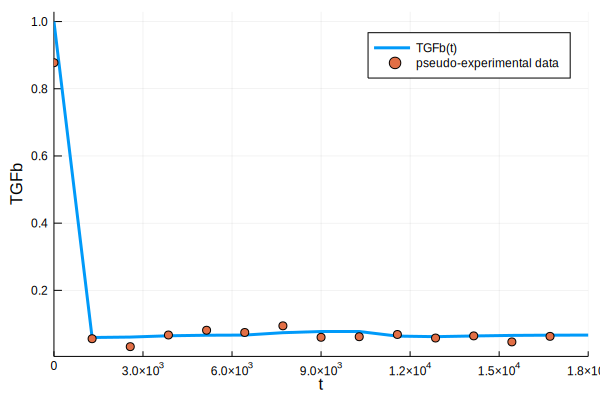

In [6]:
plot(sol, vars=(0,1), xlabel = "t", ylabel = "TGFb", label="TGFb(t)");
scatter!(dataset[!,:time],dataset[!,:TGFb], label = "pseudo-experimental data")

To fit parameters to pseudo-experimental data we use the following likelihood function provided by the authors of \[\*\] in [AMIGO2 package](https://github.com/csynbiosys/AMIGO2R2016b). According to AMIGO2 docs:

*For the homoscedastic case, for which the variance is known or constant, the cost function results
to be similar to the generalized least squares, with weights taken as the inverse of the variance of
the experimental data*

$$ \Lambda = \sum_{i=1}^n \left(\frac{y(t_i) - \tilde y_i}{\sigma_i}\right)^2 $$

Here 
$n$ - number of observations (experimental data time points),
$\tilde y_i$ - experimental data,
$y(t_i)$ - numerical solution,
$\sigma_i $ - standard deviation of heteroscedastic noise

In [6]:
# loss function 
# for 'hetero' case 
# https://github.com/csynbiosys/AMIGO2R2016b/blob/63b131e0274096f9aef6ca42d0332ff113d1828a/Kernel/AMIGO_PEcost.m#L322

function loss_func(sol, data, sigma) # sum by components
    loss = 0.0
    for i in eachindex(sol.u[1]) #1:16
        loss += loss_i(sol[i,:], data[!,i+1], sigma[!,i+1])
    end
    return loss
end

function loss_i(sol, data, sigma) # sum by data points
    loss = 0.0  
    for i in eachindex(sol)
        loss += ((sol[i] - data[i])/sigma[i])^2
    end
    return loss 
end;

Objective function is a wrapper for parameters updates during fitting `obj_func = (params)->loss`

In [7]:
# obj function (params,prob)->loss
function obj_func(params;
                  prob=prob, 
                  solver_opts=solver_opts, 
                  time_points=time_points,
                  loss=(sol)->loss_func(sol,dataset,sigmas)
)
    prob_p = remake(prob,p=params)
    sol_p = solve(prob_p, 
                  solver_opts[:alg], 
                  reltol=solver_opts[:reltol], 
                  abstol=solver_opts[:abstol], 
                  saveat=time_points,
                  save_idxs = 1:16)
    loss(sol_p)
end;

Now we fit parameters to the dataset with *NLopt* package. See [NLopt documentation](https://nlopt.readthedocs.io/en/latest) for details

In [8]:
# fitting algorithm and search bounds

fitter_opts = Dict(
    :alg => :LN_NELDERMEAD
)

# lower, upper bounds and start values formula:
# https://github.com/gabora/visid/blob/master/case_studies/tgfb/TGFB_amigo.m
lb = [1e-6, 0.0001, 1e-6, 0.0001, 1e-6, 1e-6, 1e-5, 1e-5, 1e-6, 1e-5, 0.1, 1e-5, 1e-5, 0.001, 1e-5, 1e-5, 1e-5, 1e-5]
ub = [0.1, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 100., 1.0, 1.0, 100., 0.1, 0.1, 0.1, 0.1]

# start values generated with exp.(log.(lb) + rand(length(p0)).*(log.(ub) - log.(lb)))
p_start = [3.52E-05,
           0.00131226,
           0.00151732,
           0.0395871,
           1.63E-05,
           0.000251247,
           0.000112007,
           0.00783227,
           0.0424562,
           0.000142716,
           8.20992,
           0.000270499,
           0.0213893,
           1.41254,
           0.000121978,
           0.00658392,
           0.000205464,
           0.0111338]

opt = Opt(fitter_opts[:alg], length(p0))
opt.min_objective = (p,grad) -> obj_func(p)
opt.lower_bounds = lb
opt.upper_bounds = ub
opt.xtol_rel = 1e-3

(loss,p,ret) = NLopt.optimize(opt, p_start)

(7597.967304897038, [8.214372398674075e-5, 0.038808202411743396, 0.03662576098761518, 0.00010012014996470485, 2.7719175355951243e-5, 2.474460692476516e-6, 2.694037359564942e-5, 6.0835783479742275e-5, 3.49689020694743e-5, 0.0008975699271944685, 13.125339963271827, 1.0195830763745685e-5, 0.3293022587117055, 0.2805325079979767, 0.0005521115844559219, 0.0013129571635396384, 0.0030843102504628356, 0.03274237009232267], :XTOL_REACHED)

Let's use *LikelihoodProfiler* package to determine identifiable parameters and compute confidence intrvals.
We choose identification confidence level $ \alpha = loss + 3.84$, where $loss $ is the minimum likelihood function value obtained during fitting and 3.84 is *Chi-square statistics* with 1 degree of freedom and P-value=0.05.
Please, look up [LikelihoodProfiler documentation](https://insysbio.github.io/LikelihoodProfiler.jl/latest/) for details

In [9]:
α = loss + 3.84
scan_bounds = tuple.(lb,ub)
theta_bounds = tuple.(lb/10.,ub*10)

intervals = Vector{ParamInterval}(undef,length(p))
for i in eachindex(p)
    
    intervals[i] = get_interval(
        p,
        i,
        (p)->obj_func(p),
        :CICO_ONE_PASS,
        loss_crit = α,
        theta_bounds = theta_bounds,
        scan_bounds = scan_bounds[i],
        local_alg = :LN_NELDERMEAD,
        scan_tol = 1e-4,
        #scale = fill(:log,length(p))
    )
    println(intervals[i]) 
end

[1

┌ Warning: Close-to-zero parameters found when using :LN_NELDERMEAD.
└ @ LikelihoodProfiler D:\INSYSBIO\repos\LikelihoodProfiler\src\cico_one_pass.jl:35


, 4, 5, 6, 7, 8, 9, 10, 12, 15, 16, 17][1, 4, 5, 6, 7, 8, 9, 10, 12, 15, 16, 17]

┌ Warning: Close-to-zero parameters found when using :LN_NELDERMEAD.
└ @ LikelihoodProfiler D:\INSYSBIO\repos\LikelihoodProfiler\src\cico_one_pass.jl:35


ParamInterval(ParamIntervalInput([8.214372398674075e-5, 0.038808202411743396, 0.03662576098761518, 0.00010012014996470485, 2.7719175355951243e-5, 2.474460692476516e-6, 2.694037359564942e-5, 6.0835783479742275e-5, 3.49689020694743e-5, 0.0008975699271944685, 13.125339963271827, 1.0195830763745685e-5, 0.3293022587117055, 0.2805325079979767, 0.0005521115844559219, 0.0013129571635396384, 0.0030843102504628356, 0.03274237009232267], 1, getfield(Main, Symbol("##10#11"))(), 7601.807304897038, Symbol[:direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct], Tuple{Float64,Float64}[(1.0e-7, 1.0), (1.0e-5, 10.0), (1.0e-7, 10.0), (1.0e-5, 10.0), (1.0e-7, 10.0), (1.0e-7, 10.0), (1.0000000000000002e-6, 10.0), (1.0000000000000002e-6, 10.0), (1.0e-7, 10.0), (1.0000000000000002e-6, 10.0), (0.01, 1000.0), (1.0000000000000002e-6, 10.0), (1.0000000000000002e-6, 10.0), (0.0001, 1000.0), (1.00000000000000

┌ Warning: Close-to-zero parameters found when using :LN_NELDERMEAD.
└ @ LikelihoodProfiler D:\INSYSBIO\repos\LikelihoodProfiler\src\cico_one_pass.jl:35


[1, 4, 5, 6, 7, 8, 9, 10, 12, 15, 16, 17]

┌ Warning: Close-to-zero parameters found when using :LN_NELDERMEAD.
└ @ LikelihoodProfiler D:\INSYSBIO\repos\LikelihoodProfiler\src\cico_one_pass.jl:35


ParamInterval(ParamIntervalInput([8.214372398674075e-5, 0.038808202411743396, 0.03662576098761518, 0.00010012014996470485, 2.7719175355951243e-5, 2.474460692476516e-6, 2.694037359564942e-5, 6.0835783479742275e-5, 3.49689020694743e-5, 0.0008975699271944685, 13.125339963271827, 1.0195830763745685e-5, 0.3293022587117055, 0.2805325079979767, 0.0005521115844559219, 0.0013129571635396384, 0.0030843102504628356, 0.03274237009232267], 2, getfield(Main, Symbol("##10#11"))(), 7601.807304897038, Symbol[:direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct], Tuple{Float64,Float64}[(1.0e-7, 1.0), (1.0e-5, 10.0), (1.0e-7, 10.0), (1.0e-5, 10.0), (1.0e-7, 10.0), (1.0e-7, 10.0), (1.0000000000000002e-6, 10.0), (1.0000000000000002e-6, 10.0), (1.0e-7, 10.0), (1.0000000000000002e-6, 10.0), (0.01, 1000.0), (1.0000000000000002e-6, 10.0), (1.0000000000000002e-6, 10.0), (0.0001, 1000.0), (1.00000000000000

┌ Warning: Close-to-zero parameters found when using :LN_NELDERMEAD.
└ @ LikelihoodProfiler D:\INSYSBIO\repos\LikelihoodProfiler\src\cico_one_pass.jl:35


 5, 6, 7, 8, 9, 10, 12, 15, 16, 17][1, 4, 5, 6, 7, 8, 9, 10, 12, 15, 16, 17]

┌ Warning: Close-to-zero parameters found when using :LN_NELDERMEAD.
└ @ LikelihoodProfiler D:\INSYSBIO\repos\LikelihoodProfiler\src\cico_one_pass.jl:35


ParamInterval(ParamIntervalInput([8.214372398674075e-5, 0.038808202411743396, 0.03662576098761518, 0.00010012014996470485, 2.7719175355951243e-5, 2.474460692476516e-6, 2.694037359564942e-5, 6.0835783479742275e-5, 3.49689020694743e-5, 0.0008975699271944685, 13.125339963271827, 1.0195830763745685e-5, 0.3293022587117055, 0.2805325079979767, 0.0005521115844559219, 0.0013129571635396384, 0.0030843102504628356, 0.03274237009232267], 3, getfield(Main, Symbol("##10#11"))(), 7601.807304897038, Symbol[:direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct], Tuple{Float64,Float64}[(1.0e-7, 1.0), (1.0e-5, 10.0), (1.0e-7, 10.0), (1.0e-5, 10.0), (1.0e-7, 10.0), (1.0e-7, 10.0), (1.0000000000000002e-6, 10.0), (1.0000000000000002e-6, 10.0), (1.0e-7, 10.0), (1.0000000000000002e-6, 10.0), (0.01, 1000.0), (1.0000000000000002e-6, 10.0), (1.0000000000000002e-6, 10.0), (0.0001, 1000.0), (1.00000000000000

┌ Warning: Close-to-zero parameters found when using :LN_NELDERMEAD.
└ @ LikelihoodProfiler D:\INSYSBIO\repos\LikelihoodProfiler\src\cico_one_pass.jl:35


[1, 4, 5, 6, 7, 8, 9, 10, 12, 15, 16, 17][1, 4, 5, 6, 7, 8, 9, 10, 12, 15, 16, 17]

┌ Warning: Close-to-zero parameters found when using :LN_NELDERMEAD.
└ @ LikelihoodProfiler D:\INSYSBIO\repos\LikelihoodProfiler\src\cico_one_pass.jl:35


ParamInterval(ParamIntervalInput([8.214372398674075e-5, 0.038808202411743396, 0.03662576098761518, 0.00010012014996470485, 2.7719175355951243e-5, 2.474460692476516e-6, 2.694037359564942e-5, 6.0835783479742275e-5, 3.49689020694743e-5, 0.0008975699271944685, 13.125339963271827, 1.0195830763745685e-5, 0.3293022587117055, 0.2805325079979767, 0.0005521115844559219, 0.0013129571635396384, 0.0030843102504628356, 0.03274237009232267], 4, getfield(Main, Symbol("##10#11"))(), 7601.807304897038, Symbol[:direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct], Tuple{Float64,Float64}[(1.0e-7, 1.0), (1.0e-5, 10.0), (1.0e-7, 10.0), (1.0e-5, 10.0), (1.0e-7, 10.0), (1.0e-7, 10.0), (1.0000000000000002e-6, 10.0), (1.0000000000000002e-6, 10.0), (1.0e-7, 10.0), (1.0000000000000002e-6, 10.0), (0.01, 1000.0), (1.0000000000000002e-6, 10.0), (1.0000000000000002e-6, 10.0), (0.0001, 1000.0), (1.00000000000000

┌ Warning: Close-to-zero parameters found when using :LN_NELDERMEAD.
└ @ LikelihoodProfiler D:\INSYSBIO\repos\LikelihoodProfiler\src\cico_one_pass.jl:35


[1, 4, 5, 6, 7, 8, 9, 10, 12, 15, 16, 17][1, 4, 5, 6, 7, 8, 9, 10, 12, 15, 16, 17

┌ Warning: Close-to-zero parameters found when using :LN_NELDERMEAD.
└ @ LikelihoodProfiler D:\INSYSBIO\repos\LikelihoodProfiler\src\cico_one_pass.jl:35


]ParamInterval(ParamIntervalInput([8.214372398674075e-5, 0.038808202411743396, 0.03662576098761518, 0.00010012014996470485, 2.7719175355951243e-5, 2.474460692476516e-6, 2.694037359564942e-5, 6.0835783479742275e-5, 3.49689020694743e-5, 0.0008975699271944685, 13.125339963271827, 1.0195830763745685e-5, 0.3293022587117055, 0.2805325079979767, 0.0005521115844559219, 0.0013129571635396384, 0.0030843102504628356, 0.03274237009232267], 5, getfield(Main, Symbol("##10#11"))(), 7601.807304897038, Symbol[:direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct], Tuple{Float64,Float64}[(1.0e-7, 1.0), (1.0e-5, 10.0), (1.0e-7, 10.0), (1.0e-5, 10.0), (1.0e-7, 10.0), (1.0e-7, 10.0), (1.0000000000000002e-6, 10.0), (1.0000000000000002e-6, 10.0), (1.0e-7, 10.0), (1.0000000000000002e-6, 10.0), (0.01, 1000.0), (1.0000000000000002e-6, 10.0), (1.0000000000000002e-6, 10.0), (0.0001, 1000.0), (1.0000000000000

┌ Warning: Close-to-zero parameters found when using :LN_NELDERMEAD.
└ @ LikelihoodProfiler D:\INSYSBIO\repos\LikelihoodProfiler\src\cico_one_pass.jl:35


[1, 4, 5, 6, 7, 8, 9, 10, 12, 15, 16, 17]

┌ Warning: Close-to-zero parameters found when using :LN_NELDERMEAD.
└ @ LikelihoodProfiler D:\INSYSBIO\repos\LikelihoodProfiler\src\cico_one_pass.jl:35


ParamInterval(ParamIntervalInput([8.214372398674075e-5, 0.038808202411743396, 0.03662576098761518, 0.00010012014996470485, 2.7719175355951243e-5, 2.474460692476516e-6, 2.694037359564942e-5, 6.0835783479742275e-5, 3.49689020694743e-5, 0.0008975699271944685, 13.125339963271827, 1.0195830763745685e-5, 0.3293022587117055, 0.2805325079979767, 0.0005521115844559219, 0.0013129571635396384, 0.0030843102504628356, 0.03274237009232267], 6, getfield(Main, Symbol("##10#11"))(), 7601.807304897038, Symbol[:direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct], Tuple{Float64,Float64}[(1.0e-7, 1.0), (1.0e-5, 10.0), (1.0e-7, 10.0), (1.0e-5, 10.0), (1.0e-7, 10.0), (1.0e-7, 10.0), (1.0000000000000002e-6, 10.0), (1.0000000000000002e-6, 10.0), (1.0e-7, 10.0), (1.0000000000000002e-6, 10.0), (0.01, 1000.0), (1.0000000000000002e-6, 10.0), (1.0000000000000002e-6, 10.0), (0.0001, 1000.0), (1.00000000000000

┌ Warning: Close-to-zero parameters found when using :LN_NELDERMEAD.
└ @ LikelihoodProfiler D:\INSYSBIO\repos\LikelihoodProfiler\src\cico_one_pass.jl:35


[1, 4, 5, 6, 7, 8, 9, 10, 12, 15, 16, 17]

┌ Warning: Close-to-zero parameters found when using :LN_NELDERMEAD.
└ @ LikelihoodProfiler D:\INSYSBIO\repos\LikelihoodProfiler\src\cico_one_pass.jl:35


ParamInterval(ParamIntervalInput([8.214372398674075e-5, 0.038808202411743396, 0.03662576098761518, 0.00010012014996470485, 2.7719175355951243e-5, 2.474460692476516e-6, 2.694037359564942e-5, 6.0835783479742275e-5, 3.49689020694743e-5, 0.0008975699271944685, 13.125339963271827, 1.0195830763745685e-5, 0.3293022587117055, 0.2805325079979767, 0.0005521115844559219, 0.0013129571635396384, 0.0030843102504628356, 0.03274237009232267], 7, getfield(Main, Symbol("##10#11"))(), 7601.807304897038, Symbol[:direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct], Tuple{Float64,Float64}[(1.0e-7, 1.0), (1.0e-5, 10.0), (1.0e-7, 10.0), (1.0e-5, 10.0), (1.0e-7, 10.0), (1.0e-7, 10.0), (1.0000000000000002e-6, 10.0), (1.0000000000000002e-6, 10.0), (1.0e-7, 10.0), (1.0000000000000002e-6, 10.0), (0.01, 1000.0), (1.0000000000000002e-6, 10.0), (1.0000000000000002e-6, 10.0), (0.0001, 1000.0), (1.00000000000000

┌ Warning: Close-to-zero parameters found when using :LN_NELDERMEAD.
└ @ LikelihoodProfiler D:\INSYSBIO\repos\LikelihoodProfiler\src\cico_one_pass.jl:35


][1, 4, 5, 6, 7, 8, 9, 10, 12, 15, 16, 17]

┌ Warning: Close-to-zero parameters found when using :LN_NELDERMEAD.
└ @ LikelihoodProfiler D:\INSYSBIO\repos\LikelihoodProfiler\src\cico_one_pass.jl:35


ParamInterval(ParamIntervalInput([8.214372398674075e-5, 0.038808202411743396, 0.03662576098761518, 0.00010012014996470485, 2.7719175355951243e-5, 2.474460692476516e-6, 2.694037359564942e-5, 6.0835783479742275e-5, 3.49689020694743e-5, 0.0008975699271944685, 13.125339963271827, 1.0195830763745685e-5, 0.3293022587117055, 0.2805325079979767, 0.0005521115844559219, 0.0013129571635396384, 0.0030843102504628356, 0.03274237009232267], 8, getfield(Main, Symbol("##10#11"))(), 7601.807304897038, Symbol[:direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct], Tuple{Float64,Float64}[(1.0e-7, 1.0), (1.0e-5, 10.0), (1.0e-7, 10.0), (1.0e-5, 10.0), (1.0e-7, 10.0), (1.0e-7, 10.0), (1.0000000000000002e-6, 10.0), (1.0000000000000002e-6, 10.0), (1.0e-7, 10.0), (1.0000000000000002e-6, 10.0), (0.01, 1000.0), (1.0000000000000002e-6, 10.0), (1.0000000000000002e-6, 10.0), (0.0001, 1000.0), (1.00000000000000

┌ Warning: Close-to-zero parameters found when using :LN_NELDERMEAD.
└ @ LikelihoodProfiler D:\INSYSBIO\repos\LikelihoodProfiler\src\cico_one_pass.jl:35


[1, 4, 5, 6, 7, 8, 9, 10, 12, 15, 16, 17

┌ Warning: Close-to-zero parameters found when using :LN_NELDERMEAD.
└ @ LikelihoodProfiler D:\INSYSBIO\repos\LikelihoodProfiler\src\cico_one_pass.jl:35


]ParamInterval(ParamIntervalInput([8.214372398674075e-5, 0.038808202411743396, 0.03662576098761518, 0.00010012014996470485, 2.7719175355951243e-5, 2.474460692476516e-6, 2.694037359564942e-5, 6.0835783479742275e-5, 3.49689020694743e-5, 0.0008975699271944685, 13.125339963271827, 1.0195830763745685e-5, 0.3293022587117055, 0.2805325079979767, 0.0005521115844559219, 0.0013129571635396384, 0.0030843102504628356, 0.03274237009232267], 9, getfield(Main, Symbol("##10#11"))(), 7601.807304897038, Symbol[:direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct], Tuple{Float64,Float64}[(1.0e-7, 1.0), (1.0e-5, 10.0), (1.0e-7, 10.0), (1.0e-5, 10.0), (1.0e-7, 10.0), (1.0e-7, 10.0), (1.0000000000000002e-6, 10.0), (1.0000000000000002e-6, 10.0), (1.0e-7, 10.0), (1.0000000000000002e-6, 10.0), (0.01, 1000.0), (1.0000000000000002e-6, 10.0), (1.0000000000000002e-6, 10.0), (0.0001, 1000.0), (1.0000000000000

┌ Warning: Close-to-zero parameters found when using :LN_NELDERMEAD.
└ @ LikelihoodProfiler D:\INSYSBIO\repos\LikelihoodProfiler\src\cico_one_pass.jl:35


][1, 4, 5, 6, 7, 8, 9, 10, 12, 15, 16, 17]

┌ Warning: Close-to-zero parameters found when using :LN_NELDERMEAD.
└ @ LikelihoodProfiler D:\INSYSBIO\repos\LikelihoodProfiler\src\cico_one_pass.jl:35


ParamInterval(ParamIntervalInput([8.214372398674075e-5, 0.038808202411743396, 0.03662576098761518, 0.00010012014996470485, 2.7719175355951243e-5, 2.474460692476516e-6, 2.694037359564942e-5, 6.0835783479742275e-5, 3.49689020694743e-5, 0.0008975699271944685, 13.125339963271827, 1.0195830763745685e-5, 0.3293022587117055, 0.2805325079979767, 0.0005521115844559219, 0.0013129571635396384, 0.0030843102504628356, 0.03274237009232267], 10, getfield(Main, Symbol("##10#11"))(), 7601.807304897038, Symbol[:direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct], Tuple{Float64,Float64}[(1.0e-7, 1.0), (1.0e-5, 10.0), (1.0e-7, 10.0), (1.0e-5, 10.0), (1.0e-7, 10.0), (1.0e-7, 10.0), (1.0000000000000002e-6, 10.0), (1.0000000000000002e-6, 10.0), (1.0e-7, 10.0), (1.0000000000000002e-6, 10.0), (0.01, 1000.0), (1.0000000000000002e-6, 10.0), (1.0000000000000002e-6, 10.0), (0.0001, 1000.0), (1.0000000000000

┌ Warning: Close-to-zero parameters found when using :LN_NELDERMEAD.
└ @ LikelihoodProfiler D:\INSYSBIO\repos\LikelihoodProfiler\src\cico_one_pass.jl:35


[1, 4, 5, 6, 7, 8, 9, 10, 12, 15, 16, 17]

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ DiffEqBase C:\Julia-1.2.0\packages\DiffEqBase\V40QH\src\integrator_interface.jl:162


[1, 4, 5, 6, 7, 8, 9, 10, 12, 15, 16, 17

┌ Warning: Close-to-zero parameters found when using :LN_NELDERMEAD.
└ @ LikelihoodProfiler D:\INSYSBIO\repos\LikelihoodProfiler\src\cico_one_pass.jl:35


]

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ DiffEqBase C:\Julia-1.2.0\packages\DiffEqBase\V40QH\src\integrator_interface.jl:162
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ DiffEqBase C:\Julia-1.2.0\packages\DiffEqBase\V40QH\src\integrator_interface.jl:162
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ DiffEqBase C:\Julia-1.2.0\packages\DiffEqBase\V40QH\src\integrator_interface.jl:162
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ DiffEqBase C:\Julia-1.2.0\packages\DiffEqBase\V40QH\src\integrator_interface.jl:162
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ DiffEqBase C:\Julia-1.2.0\packages\Diff

ParamInterval(ParamIntervalInput([8.214372398674075e-5, 0.038808202411743396, 0.03662576098761518, 0.00010012014996470485, 2.7719175355951243e-5, 2.474460692476516e-6, 2.694037359564942e-5, 6.0835783479742275e-5, 3.49689020694743e-5, 0.0008975699271944685, 13.125339963271827, 1.0195830763745685e-5, 0.3293022587117055, 0.2805325079979767, 0.0005521115844559219, 0.0013129571635396384, 0.0030843102504628356, 0.03274237009232267], 11, getfield(Main, Symbol("##10#11"))(), 7601.807304897038, Symbol[:direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct], Tuple{Float64,Float64}[(1.0e-7, 1.0), (1.0e-5, 10.0), (1.0e-7, 10.0), (1.0e-5, 10.0), (1.0e-7, 10.0), (1.0e-7, 10.0), (1.0000000000000002e-6, 10.0), (1.0000000000000002e-6, 10.0), (1.0e-7, 10.0), (1.0000000000000002e-6, 10.0), (0.01, 1000.0), (1.0000000000000002e-6, 10.0), (1.0000000000000002e-6, 10.0), (0.0001, 1000.0), (1.0000000000000

┌ Warning: Close-to-zero parameters found when using :LN_NELDERMEAD.
└ @ LikelihoodProfiler D:\INSYSBIO\repos\LikelihoodProfiler\src\cico_one_pass.jl:35


[1, 4, 5, 6, 7, 8, 9, 10, 12, 15, 16, 17]

┌ Warning: Close-to-zero parameters found when using :LN_NELDERMEAD.
└ @ LikelihoodProfiler D:\INSYSBIO\repos\LikelihoodProfiler\src\cico_one_pass.jl:35


ParamInterval(ParamIntervalInput([8.214372398674075e-5, 0.038808202411743396, 0.03662576098761518, 0.00010012014996470485, 2.7719175355951243e-5, 2.474460692476516e-6, 2.694037359564942e-5, 6.0835783479742275e-5, 3.49689020694743e-5, 0.0008975699271944685, 13.125339963271827, 1.0195830763745685e-5, 0.3293022587117055, 0.2805325079979767, 0.0005521115844559219, 0.0013129571635396384, 0.0030843102504628356, 0.03274237009232267], 12, getfield(Main, Symbol("##10#11"))(), 7601.807304897038, Symbol[:direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct], Tuple{Float64,Float64}[(1.0e-7, 1.0), (1.0e-5, 10.0), (1.0e-7, 10.0), (1.0e-5, 10.0), (1.0e-7, 10.0), (1.0e-7, 10.0), (1.0000000000000002e-6, 10.0), (1.0000000000000002e-6, 10.0), (1.0e-7, 10.0), (1.0000000000000002e-6, 10.0), (0.01, 1000.0), (1.0000000000000002e-6, 10.0), (1.0000000000000002e-6, 10.0), (0.0001, 1000.0), (1.0000000000000

┌ Warning: Close-to-zero parameters found when using :LN_NELDERMEAD.
└ @ LikelihoodProfiler D:\INSYSBIO\repos\LikelihoodProfiler\src\cico_one_pass.jl:35


]

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ DiffEqBase C:\Julia-1.2.0\packages\DiffEqBase\V40QH\src\integrator_interface.jl:162


[1, 4, 5, 6, 7, 8, 9, 10, 12, 15, 16, 17]

┌ Warning: Close-to-zero parameters found when using :LN_NELDERMEAD.
└ @ LikelihoodProfiler D:\INSYSBIO\repos\LikelihoodProfiler\src\cico_one_pass.jl:35


ParamInterval(ParamIntervalInput([8.214372398674075e-5, 0.038808202411743396, 0.03662576098761518, 0.00010012014996470485, 2.7719175355951243e-5, 2.474460692476516e-6, 2.694037359564942e-5, 6.0835783479742275e-5, 3.49689020694743e-5, 0.0008975699271944685, 13.125339963271827, 1.0195830763745685e-5, 0.3293022587117055, 0.2805325079979767, 0.0005521115844559219, 0.0013129571635396384, 0.0030843102504628356, 0.03274237009232267], 13, getfield(Main, Symbol("##10#11"))(), 7601.807304897038, Symbol[:direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct], Tuple{Float64,Float64}[(1.0e-7, 1.0), (1.0e-5, 10.0), (1.0e-7, 10.0), (1.0e-5, 10.0), (1.0e-7, 10.0), (1.0e-7, 10.0), (1.0000000000000002e-6, 10.0), (1.0000000000000002e-6, 10.0), (1.0e-7, 10.0), (1.0000000000000002e-6, 10.0), (0.01, 1000.0), (1.0000000000000002e-6, 10.0), (1.0000000000000002e-6, 10.0), (0.0001, 1000.0), (1.0000000000000

┌ Warning: Close-to-zero parameters found when using :LN_NELDERMEAD.
└ @ LikelihoodProfiler D:\INSYSBIO\repos\LikelihoodProfiler\src\cico_one_pass.jl:35


[1, 4, 5, 6, 7, 8, 9, 10, 12, 15, 16, 17]

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ DiffEqBase C:\Julia-1.2.0\packages\DiffEqBase\V40QH\src\integrator_interface.jl:162


[1, 4, 5, 6, 7, 8, 9, 10, 12, 15, 16, 17]

┌ Warning: Close-to-zero parameters found when using :LN_NELDERMEAD.
└ @ LikelihoodProfiler D:\INSYSBIO\repos\LikelihoodProfiler\src\cico_one_pass.jl:35
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ DiffEqBase C:\Julia-1.2.0\packages\DiffEqBase\V40QH\src\integrator_interface.jl:162
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ DiffEqBase C:\Julia-1.2.0\packages\DiffEqBase\V40QH\src\integrator_interface.jl:162


ParamInterval(ParamIntervalInput([8.214372398674075e-5, 0.038808202411743396, 0.03662576098761518, 0.00010012014996470485, 2.7719175355951243e-5, 2.474460692476516e-6, 2.694037359564942e-5, 6.0835783479742275e-5, 3.49689020694743e-5, 0.0008975699271944685, 13.125339963271827, 1.0195830763745685e-5, 0.3293022587117055, 0.2805325079979767, 0.0005521115844559219, 0.0013129571635396384, 0.0030843102504628356, 0.03274237009232267], 14, getfield(Main, Symbol("##10#11"))(), 7601.807304897038, Symbol[:direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct], Tuple{Float64,Float64}[(1.0e-7, 1.0), (1.0e-5, 10.0), (1.0e-7, 10.0), (1.0e-5, 10.0), (1.0e-7, 10.0), (1.0e-7, 10.0), (1.0000000000000002e-6, 10.0), (1.0000000000000002e-6, 10.0), (1.0e-7, 10.0), (1.0000000000000002e-6, 10.0), (0.01, 1000.0), (1.0000000000000002e-6, 10.0), (1.0000000000000002e-6, 10.0), (0.0001, 1000.0), (1.0000000000000

┌ Warning: Close-to-zero parameters found when using :LN_NELDERMEAD.
└ @ LikelihoodProfiler D:\INSYSBIO\repos\LikelihoodProfiler\src\cico_one_pass.jl:35
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ DiffEqBase C:\Julia-1.2.0\packages\DiffEqBase\V40QH\src\integrator_interface.jl:162


[1, 4, 5, 6, 7, 8, 9, 10, 12, 15, 16, 17]

┌ Warning: Close-to-zero parameters found when using :LN_NELDERMEAD.
└ @ LikelihoodProfiler D:\INSYSBIO\repos\LikelihoodProfiler\src\cico_one_pass.jl:35
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ DiffEqBase C:\Julia-1.2.0\packages\DiffEqBase\V40QH\src\integrator_interface.jl:162
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ DiffEqBase C:\Julia-1.2.0\packages\DiffEqBase\V40QH\src\integrator_interface.jl:162
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ DiffEqBase C:\Julia-1.2.0\packages\DiffEqBase\V40QH\src\integrator_interface.jl:162
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ DiffEqBase C:\Julia-1.2.0\packages\DiffEqBase\V40QH\src\integrator_interface.jl:162
┌ Warning: 

ParamInterval(ParamIntervalInput([8.214372398674075e-5, 0.038808202411743396, 0.03662576098761518, 0.00010012014996470485, 2.7719175355951243e-5, 2.474460692476516e-6, 2.694037359564942e-5, 6.0835783479742275e-5, 3.49689020694743e-5, 0.0008975699271944685, 13.125339963271827, 1.0195830763745685e-5, 0.3293022587117055, 0.2805325079979767, 0.0005521115844559219, 0.0013129571635396384, 0.0030843102504628356, 0.03274237009232267], 15, getfield(Main, Symbol("##10#11"))(), 7601.807304897038, Symbol[:direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct], Tuple{Float64,Float64}[(1.0e-7, 1.0), (1.0e-5, 10.0), (1.0e-7, 10.0), (1.0e-5, 10.0), (1.0e-7, 10.0), (1.0e-7, 10.0), (1.0000000000000002e-6, 10.0), (1.0000000000000002e-6, 10.0), (1.0e-7, 10.0), (1.0000000000000002e-6, 10.0), (0.01, 1000.0), (1.0000000000000002e-6, 10.0), (1.0000000000000002e-6, 10.0), (0.0001, 1000.0), (1.0000000000000

┌ Warning: Close-to-zero parameters found when using :LN_NELDERMEAD.
└ @ LikelihoodProfiler D:\INSYSBIO\repos\LikelihoodProfiler\src\cico_one_pass.jl:35
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ DiffEqBase C:\Julia-1.2.0\packages\DiffEqBase\V40QH\src\integrator_interface.jl:162


[1, 4, 5, 6, 7, 8, 9, 10, 12, 15, 16, 17

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ DiffEqBase C:\Julia-1.2.0\packages\DiffEqBase\V40QH\src\integrator_interface.jl:162
┌ Warning: Close-to-zero parameters found when using :LN_NELDERMEAD.
└ @ LikelihoodProfiler D:\INSYSBIO\repos\LikelihoodProfiler\src\cico_one_pass.jl:35


]ParamInterval(ParamIntervalInput([8.214372398674075e-5, 0.038808202411743396, 0.03662576098761518, 0.00010012014996470485, 2.7719175355951243e-5, 2.474460692476516e-6, 2.694037359564942e-5, 6.0835783479742275e-5, 3.49689020694743e-5, 0.0008975699271944685, 13.125339963271827, 1.0195830763745685e-5, 0.3293022587117055, 0.2805325079979767, 0.0005521115844559219, 0.0013129571635396384, 0.0030843102504628356, 0.03274237009232267], 16, getfield(Main, Symbol("##10#11"))(), 7601.807304897038, Symbol[:direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct], Tuple{Float64,Float64}[(1.0e-7, 1.0), (1.0e-5, 10.0), (1.0e-7, 10.0), (1.0e-5, 10.0), (1.0e-7, 10.0), (1.0e-7, 10.0), (1.0000000000000002e-6, 10.0), (1.0000000000000002e-6, 10.0), (1.0e-7, 10.0), (1.0000000000000002e-6, 10.0), (0.01, 1000.0), (1.0000000000000002e-6, 10.0), (1.0000000000000002e-6, 10.0), (0.0001, 1000.0), (1.000000000000

┌ Warning: Close-to-zero parameters found when using :LN_NELDERMEAD.
└ @ LikelihoodProfiler D:\INSYSBIO\repos\LikelihoodProfiler\src\cico_one_pass.jl:35


[1, 4, 5, 6, 7, 8, 9, 10, 12, 15, 16, 17]

┌ Warning: Close-to-zero parameters found when using :LN_NELDERMEAD.
└ @ LikelihoodProfiler D:\INSYSBIO\repos\LikelihoodProfiler\src\cico_one_pass.jl:35


ParamInterval(ParamIntervalInput([8.214372398674075e-5, 0.038808202411743396, 0.03662576098761518, 0.00010012014996470485, 2.7719175355951243e-5, 2.474460692476516e-6, 2.694037359564942e-5, 6.0835783479742275e-5, 3.49689020694743e-5, 0.0008975699271944685, 13.125339963271827, 1.0195830763745685e-5, 0.3293022587117055, 0.2805325079979767, 0.0005521115844559219, 0.0013129571635396384, 0.0030843102504628356, 0.03274237009232267], 17, getfield(Main, Symbol("##10#11"))(), 7601.807304897038, Symbol[:direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct], Tuple{Float64,Float64}[(1.0e-7, 1.0), (1.0e-5, 10.0), (1.0e-7, 10.0), (1.0e-5, 10.0), (1.0e-7, 10.0), (1.0e-7, 10.0), (1.0000000000000002e-6, 10.0), (1.0000000000000002e-6, 10.0), (1.0e-7, 10.0), (1.0000000000000002e-6, 10.0), (0.01, 1000.0), (1.0000000000000002e-6, 10.0), (1.0000000000000002e-6, 10.0), (0.0001, 1000.0), (1.0000000000000

┌ Warning: Close-to-zero parameters found when using :LN_NELDERMEAD.
└ @ LikelihoodProfiler D:\INSYSBIO\repos\LikelihoodProfiler\src\cico_one_pass.jl:35


]

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ DiffEqBase C:\Julia-1.2.0\packages\DiffEqBase\V40QH\src\integrator_interface.jl:162


[1, 4, 5, 6, 7, 8, 9, 10, 12, 15, 16, 17

┌ Warning: Close-to-zero parameters found when using :LN_NELDERMEAD.
└ @ LikelihoodProfiler D:\INSYSBIO\repos\LikelihoodProfiler\src\cico_one_pass.jl:35


]

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ DiffEqBase C:\Julia-1.2.0\packages\DiffEqBase\V40QH\src\integrator_interface.jl:162


ParamInterval(ParamIntervalInput([8.214372398674075e-5, 0.038808202411743396, 0.03662576098761518, 0.00010012014996470485, 2.7719175355951243e-5, 2.474460692476516e-6, 2.694037359564942e-5, 6.0835783479742275e-5, 3.49689020694743e-5, 0.0008975699271944685, 13.125339963271827, 1.0195830763745685e-5, 0.3293022587117055, 0.2805325079979767, 0.0005521115844559219, 0.0013129571635396384, 0.0030843102504628356, 0.03274237009232267], 18, getfield(Main, Symbol("##10#11"))(), 7601.807304897038, Symbol[:direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct, :direct], Tuple{Float64,Float64}[(1.0e-7, 1.0), (1.0e-5, 10.0), (1.0e-7, 10.0), (1.0e-5, 10.0), (1.0e-7, 10.0), (1.0e-7, 10.0), (1.0000000000000002e-6, 10.0), (1.0000000000000002e-6, 10.0), (1.0e-7, 10.0), (1.0000000000000002e-6, 10.0), (0.01, 1000.0), (1.0000000000000002e-6, 10.0), (1.0000000000000002e-6, 10.0), (0.0001, 1000.0), (1.0000000000000

In [10]:
ENV["COLUMNS"]=120
df_res = DataFrame(
    Parameter = [:k1, :k2, :k4, :k5, :k6, :k7, :k8, :k9, :k10, :k11, :k12, :k13, :k14, :k15, :k16, :k17, :k18, :k19], 
    Status_lower = [k.result[1].status for k in intervals],
    Status_upper = [k.result[2].status for k in intervals],
    CI_lower = [k.result[1].value for k in intervals],
    CI_upper = [k.result[2].value for k in intervals],
    Fitted_value = p,
    Start_values = p_start,
    Nominal_values = p0
)
df_res

,Parameter,Status_lower,Status_upper,CI_lower,CI_upper,Fitted_value,Start_values,Nominal_values
,Symbol,Symbol,Symbol,Union…,Union…,Float64,Float64,Float64
1,k1,BORDER_FOUND_BY_SCAN_TOL,BORDER_FOUND_BY_SCAN_TOL,8.21437e-5,0.000164287,8.21437e-5,3.52e-5,0.00015
2,k2,BORDER_FOUND_BY_SCAN_TOL,SCAN_BOUND_REACHED,0.00304255,,0.0388082,0.00131226,0.023
3,k4,BORDER_FOUND_BY_SCAN_TOL,BORDER_FOUND_BY_SCAN_TOL,0.0121012,0.0739663,0.0366258,0.00151732,0.01
4,k5,SCAN_BOUND_REACHED,BORDER_FOUND_BY_SCAN_TOL,,0.00010012,0.00010012,0.0395871,0.01
5,k6,BORDER_FOUND_BY_SCAN_TOL,BORDER_FOUND_BY_SCAN_TOL,2.77192e-5,5.69229e-5,2.77192e-5,1.63e-5,0.1
6,k7,BORDER_FOUND_BY_SCAN_TOL,BORDER_FOUND_BY_SCAN_TOL,2.47446e-6,3.68333e-6,2.47446e-6,0.000251247,0.000404
7,k8,BORDER_FOUND_BY_SCAN_TOL,BORDER_FOUND_BY_SCAN_TOL,2.69404e-5,3.41008e-5,2.69404e-5,0.000112007,0.0026
8,k9,BORDER_FOUND_BY_SCAN_TOL,BORDER_FOUND_BY_SCAN_TOL,6.08358e-5,7.7416e-5,6.08358e-5,0.00783227,0.0056
9,k10,BORDER_FOUND_BY_SCAN_TOL,BORDER_FOUND_BY_SCAN_TOL,2.71506e-5,3.70266e-5,3.49689e-5,0.0424562,0.002
